#### Data processing notebook

This notebook will process the data acquired on experiments around the latency to fetch a file from an S3 bucket directly or passing through AWS CDN, a.k.a CloudFront.

#### Methodology

An S3 bucket is deployed in each continent 

["sa-east-1", "us-east-1", "af-south-1", "ap-northeast-1", "eu-west-1", "ap-southeast-2"](https://github.com/gpspelle/cdk-s3-cdn-experiment/blob/main/cdk/bin/pfg.ts#L53)

São Paulo, North Virginia, South Africa, Tokyo, Ireland, Sydney.

On top of that, CloudFront is deployed and is serving the content from each ofthese buckets from a specific route. So, if https://gpspelle.click is the domain used by CloudFront, https://gpspelle.click/sa-east-1/* requests are redirected to the São Paulo (sa-east-1) bucket.

To measure the difference of performance with or without cloudfront, for each region, the files from the bucket are fetched passing through cloudfront and not passing through it. There's a log containing the result of these requests for each region.

Each file consists of a fixed amount of lines, in our early experiments, it's 10, where each line contains the following information:


- ProcessDate := when the fetch request was executed
- SourceUrl := URL used to get the content, it can be a CF url or an S3 url
- FileSize := size of the file that is fetched
- ElapsedTime := time to fetch the file
- StatusCode := status code of the request

For now, we are considering files with [1kb, 10kb, 100kb, 1000kb](https://github.com/gpspelle/cdk-s3-cdn-experiment/blob/main/utils/fetchFiles.cjs#L112)


If you are running on a mac m1: brew install gdal proj

In [ ]:
!pip install -r requirements.txt

In [1]:
# Helper function to get the .csv files generated by the fetch command
from os import listdir

def find_csv_filenames(path_to_dir, suffix=".csv"):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [2]:
filenames = find_csv_filenames(".")
print(filenames[0])

log-sa-east-1-20220511155438.csv


In [9]:
import pandas as pd

df = pd.read_csv(filenames[0])
assert (df['StatusCode'] == 200).all()

In [10]:
df.drop(columns=['StatusCode'], inplace=True)

In [13]:
file_sizes = ["1kb", "10kb", "100kb", "1000kb"]
dfs = {}
for file_size in file_sizes:
    df_file_size = df[df['FileSize'] == file_size]
    df_file_size = df_file_size.groupby('SourceUrl')
    dfs[file_size] = df_file_size

Fontconfig warning: ignoring UTF-8: not a valid region tag


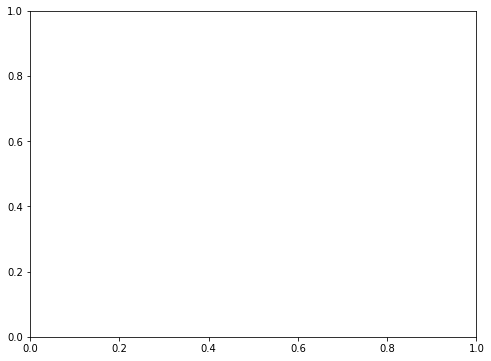

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))

<AxesSubplot:>

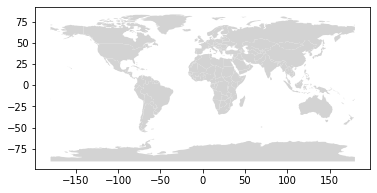

In [18]:
countries.plot(color="lightgrey")

                                                   ElapsedTime               \
                                                         count         mean   
SourceUrl                                                                     
https://gpspelle.click/sa-east-1/1000kb                   10.0   208.146046   
https://gpspelle.click/sa-east-1/100kb                    10.0   231.219592   
https://gpspelle.click/sa-east-1/10kb                     10.0   336.925267   
https://gpspelle.click/sa-east-1/1kb                      10.0   733.895829   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...        10.0  1188.853096   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...        10.0   339.315238   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...        10.0   186.765679   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...        10.0   144.753538   

                                                                            \
                                                    